# NLP Lab8 - Neural search for question answering

**Author: Bartłomiej Jamiołkowski**

The exercise introduces the problem of passage retrieval, an important step in factual question answering. 
This part concentrates on the methods for retrieving
the content of documents that might be useful for answering the question. We compare lexical text
representations (e.g. ElasticSearch default behaviour), with dense text representations (e.g. [multilingual E5](https://huggingface.co/intfloat/multilingual-e5-base) neural mode).


In [2]:
from datasets import load_dataset, Dataset
from haystack.document_stores import FAISSDocumentStore
from haystack.nodes import EmbeddingRetriever
from transformers import AutoTokenizer, Trainer, AutoModelForSequenceClassification, TrainingArguments
from scipy.special import softmax
from tqdm import tqdm

import pandas as pd
import numpy as np
import time
import math
import datasets
datasets.disable_progress_bar()
datasets.logging.set_verbosity_error()
import warnings
warnings.filterwarnings('ignore')

## Tasks 1 -2

Read the documentation of the [document store](https://docs.haystack.deepset.ai/docs/document_store) and
   the [retriever](https://docs.haystack.deepset.ai/docs/retriever) in the 
   [Haystack framework](https://haystack.deepset.ai/

Install Haystack framework (e.g. with `pip install 'farm-haystack[all]'`).).

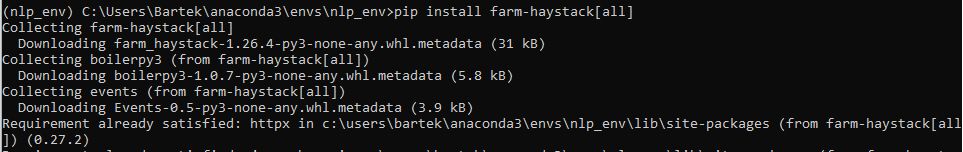

## Task 3

Configure a document store based on Faiss supported by multilingual E5 model:
   1. For Faiss use [multilingual E5](https://huggingface.co/intfloat/multilingual-e5-base) or [silver retriever base](https://huggingface.co/ipipan/silver-retriever-base-v1) encoder.
   3. **Warning:** If you use E5, make sure to [properly configure](https://github.com/deepset-ai/haystack/issues/5242) the store.
   4. In the case you have problems using Faiss, you can use `InMemoryDocumentStore`, but this will require to re-index
      all documents each time the script is run, which is time consuming.

In [2]:
def get_retriever_scheme(document_store, model, k):
    retriever = EmbeddingRetriever(
        document_store = document_store,
        embedding_model = model,
        model_format = 'transformers',
        pooling_strategy = 'reduce_mean',
        top_k = k,
        max_seq_len = 512,
    )
    
    return retriever

In [3]:
def set_retriever(index_name: str, model: str, data: pd.DataFrame, k: int) -> EmbeddingRetriever:
    try:
        document_store = FAISSDocumentStore(sql_url = f'sqlite:///{index_name}.db', similarity = 'cosine',  embedding_dim = 768)
        retriever = get_retriever_scheme(document_store, model, k)
        passages_json = [{"content": "passage: " + row["text"], "meta": {"id": int(row["_id"])}} for _, row in data.iterrows()]
        document_store.write_documents(passages_json)
        document_store.update_embeddings(retriever)
        document_store.save(index_path = index_name)
    except Exception as e:
        document_store = FAISSDocumentStore.load(index_name)
        retriever = get_retriever_scheme(document_store, model, k)

    return retriever

## Task 4

Load the documents (passages) from the FiQA corpus.

In [4]:
fiqa_pl = load_dataset('clarin-knext/fiqa-pl', 'corpus')
fiqa_pl_df = fiqa_pl['corpus'].to_pandas()
fiqa_pl_df['_id'] = fiqa_pl_df["_id"].apply(lambda x: int(x))
fiqa_pl_df.head()

,_id,title,text
0,3,,"Nie mówię, że nie podoba mi się też pomysł szk..."
1,31,,Tak więc nic nie zapobiega fałszywym ocenom po...
2,56,,Nigdy nie możesz korzystać z FSA dla indywidua...
3,59,,Samsung stworzył LCD i inne technologie płaski...
4,63,,Oto wymagania SEC: Federalne przepisy dotycząc...


In [5]:
multilingual_e5_retriever = set_retriever('multilingual_e5', 'intfloat/multilingual-e5-base', fiqa_pl_df, 5)

## Task 5

Use the set of questions and the scorings defined in this corpus, to compute NDCG@5 for the dense retriever.

In [6]:
fiqa_pl_queries_df = load_dataset('clarin-knext/fiqa-pl', 'queries')['queries'].to_pandas()
fiqa_pl_queries_df['_id'] = fiqa_pl_queries_df['_id'].apply(lambda x: int(x))
fiqa_pl_queries_df.head()

,_id,title,text
0,0,,Co jest uważane za wydatek służbowy w podróży ...
1,4,,Wydatki służbowe - ubezpieczenie samochodu pod...
2,5,,Rozpoczęcie nowego biznesu online
3,6,,„Dzień roboczy” i „termin płatności” rachunków
4,7,,Nowy właściciel firmy – Jak działają podatki d...


In [7]:
fiqa_pl_test_df = load_dataset('clarin-knext/fiqa-pl-qrels', 'default')['test'].to_pandas()
fiqa_pl_test_df.head()

,query-id,corpus-id,score
0,8,566392,1
1,8,65404,1
2,15,325273,1
3,18,88124,1
4,26,285255,1


In [16]:
def compute_ncdgk(answers_ids, revelant_ids, k):
    dcg = sum(1 / math.log(i + 2, 2) for i in range(k) if int(answers_ids[i]) in revelant_ids)
    idcg = sum(1 / math.log(i + 2, 2) for i in range(min(len(revelant_ids), k)))
    
    return dcg / idcg

def compute_analyzer_mean_ncdgn(retriever, k):
    ncdgk_scores = []
    
    for query_id in tqdm(fiqa_pl_test_df['query-id'].unique(), desc = 'Processing'):
        query = fiqa_pl_queries_df[query_id == fiqa_pl_queries_df['_id']].iloc[0]['text'] 
        answers = retriever.retrieve(query = 'query: ' + query, top_k = k)         
        answers_ids = [answer.meta['id'] for answer in answers]
        relevant_ids = fiqa_pl_test_df[query_id == fiqa_pl_test_df['query-id']]['corpus-id'].tolist()
        ncdgk_score = compute_ncdgk(answers_ids, relevant_ids, k = k)
        ncdgk_scores.append(ncdgk_score)

    return np.mean(ncdgk_scores)

In [11]:
start_time = time.time()
ndgc5_dense_retriever = compute_analyzer_mean_ncdgn(multilingual_e5_retriever, 5)
end_time = time.time()
total_time = end_time - start_time

Processing: 100%|██████████| 648/648 [04:08<00:00,  2.60it/s]


In [12]:
print(f'Mean NCDG@5 for the dense retriever: {ndgc5_dense_retriever}\nTime: {total_time}')

Mean NCDG@5 for the dense retriever: 0.23468295908732414
Time: 248.8029489517212


## Task 6

Compare the NDCG score from this exercise with the score from [lab 2](2-fts.md) and from [lab 6](6-classification.md).

The NDCG@5 score obtained in Task 5 is higher than the scores obtained in Lab 2 and Lab 6 (my Lab 5 this year). In my opinion, it is a very good result (about 0.2347), better than the result obtained for Elasticsearch (0.1851) in Lab 2 and the result obtained for the trained model in Lab 5.

## Task 7

**Bonus** (+2p) Combine dense retrieval with classification model from [lab 6](6-classification.md) to implement a two-step
   retrieval. Compute NDCG@5 for this combined model.

In [13]:
def compute_analyzer_mean_ncdgn(trainer, tokenizer, retriever, k):
    ncdgk_scores = []
    
    for query_id in tqdm(fiqa_pl_test_df['query-id'].unique(), desc = 'Processing'):
        query = fiqa_pl_queries_df[query_id == fiqa_pl_queries_df['_id']].iloc[0]['text']
        answers = retriever.retrieve(query = 'query: ' + query, top_k = k)         
        answers_ids = [answer.meta['id'] for answer in answers]
        query_answer_df = pd.DataFrame([[query, fiqa_pl_df[fiqa_pl_df['_id'] == answer_id]['text'].values[0]] for answer_id in answers_ids
                                       if len(fiqa_pl_df[fiqa_pl_df['_id'] == answer_id]['text'].values) != 0], columns = ['query', 'answer'])
        dataset = Dataset.from_pandas(query_answer_df)
        tokenized_dataset = dataset.map(lambda example: tokenizer(example['query'], example['answer'], truncation = True, padding = 'max_length'))
        predictions = trainer.predict(tokenized_dataset)
        predictions = softmax(predictions.predictions, axis = 1)
        predictions_with_ids = sorted(zip(predictions.tolist(), answers_ids), key = lambda x: x[0][1], reverse = True)
        top5_predictions_with_ids = [element[1] for element in predictions_with_ids][:5]
        relevant_ids = fiqa_pl_test_df[query_id == fiqa_pl_test_df['query-id']]['corpus-id'].tolist()
        ncdgk_score = compute_ncdgk(top5_predictions_with_ids, relevant_ids, k = k)
        ncdgk_scores.append(ncdgk_score)

    return np.mean(ncdgk_scores)

In [14]:
trainer = Trainer(
    AutoModelForSequenceClassification.from_pretrained('checkpoints/checkpoint-10000'),
    TrainingArguments(output_dir = './results', per_device_eval_batch_size = 2)
)
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
start_time = time.time()
ndgc5_combined_model = compute_analyzer_mean_ncdgn(trainer, tokenizer, multilingual_e5_retriever, 5)
end_time = time.time()
total_time = end_time - start_time

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.01 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.38 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.00 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.85 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.19 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.37 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.47 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.22 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.49 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.33 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.45 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.12 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.44 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.95 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.34 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.02 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.09 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.15 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.99 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.39 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.60 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.55 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.03 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.40 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.10 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.09 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.39 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.43 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.49 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.71 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.19 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.69 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.41 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.50 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.22 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.41 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.55 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.02 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.48 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.64 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.99 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.10 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.40 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.30 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.99 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.18 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.37 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.42 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.37 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.12 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.10 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.47 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.08 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.37 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.40 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.15 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.22 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.34 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.15 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.49 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.83 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.23 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.10 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.10 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.66 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.46 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.66 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.99 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.42 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.22 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.05 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.22 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.99 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.43 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.22 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.23 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.33 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.40 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.60 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.40 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.45 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.05 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.15 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.47 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.74 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.40 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.95 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.60 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.97 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.48 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.04 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.12 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.81 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.93 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.04 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.10 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.19 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.02 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.12 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.87 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.87 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.49 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.43 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.07 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.56 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.00 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.82 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.18 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.43 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.09 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.51 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.03 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.95 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.07 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.42 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.38 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.11 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.11 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.54 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.34 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.33 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.15 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.29 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.38 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.23 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.22 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.22 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.18 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.96 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.37 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.49 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.18 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.41 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.39 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.19 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.37 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.50 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.93 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.11 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.48 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.33 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.47 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.43 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.44 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.84 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.57 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.12 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.39 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.98 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.34 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.06 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.06 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.08 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.12 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.50 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.46 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.98 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.42 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.48 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.06 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.12 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.44 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.05 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.99 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.15 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.18 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.98 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.97 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.34 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.44 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.33 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.42 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.96 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.34 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.51 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.51 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.39 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.19 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.38 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.97 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.53 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.10 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.23 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.11 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.19 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.00 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.07 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.04 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.46 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.59 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.29 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.04 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.23 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.00 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.06 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.53 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.49 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.40 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.09 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.07 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.22 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.19 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.85 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.10 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.03 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.07 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.59 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.29 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.47 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.38 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.56 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.34 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.94 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.99 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.97 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.05 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.05 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.54 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.99 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.52 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.33 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.38 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.93 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.15 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.98 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.34 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.29 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.37 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.18 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.42 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.98 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.11 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.29 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.19 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.09 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.93 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.34 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.18 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.47 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.41 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.07 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.99 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.50 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.02 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.18 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.89 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.98 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.70 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.43 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.18 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.07 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.10 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.22 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.08 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.43 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.34 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.46 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.39 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.30 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.01 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.38 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.41 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.10 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.33 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.29 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.47 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.15 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.34 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.30 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.37 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.19 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.23 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.44 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.03 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.33 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.33 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.22 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.53 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.15 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.01 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.64 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.33 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.90 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.02 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.12 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.83 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.22 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.08 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.46 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.04 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.23 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.30 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.78 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.81 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.61 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.45 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.01 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.89 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.83 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.86 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.50 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.96 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.90 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.06 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.93 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.52 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.60 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.15 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.95 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.97 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.33 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.88 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.04 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.29 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.34 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.08 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.97 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.02 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.41 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.62 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.27 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.05 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.04 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.01 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.47 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.18 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.98 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.22 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.19 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.23 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.42 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.96 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.23 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.23 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.15 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.92 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.82 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.04 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.20 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.38 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.03 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.95 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.11 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.01 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.18 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.95 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.83 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.24 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.04 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.86 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.89 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.97 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.89 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.25 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.96 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.35 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.29 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.29 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.75 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.26 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.11 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.76 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.88 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.85 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.23 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.18 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.11 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.38 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.95 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.11 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.04 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.05 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.19 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.52 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.10 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.33 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.41 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.11 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.48 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.45 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.39 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.14 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.32 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.28 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.39 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.31 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.92 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.93 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.36 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.21 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.93 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.34 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.39 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.29 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.11 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.06 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.88 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.42 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.96 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.49 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.13 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.16 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.17 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.00 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.98 Batches/s]


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.97 Batches/s]


Processing: 100%|██████████| 648/648 [20:36<00:00,  1.91s/it]


In [15]:
print(f'Mean NCDG@5 for combined model: {ndgc5_combined_model}\nTime: {total_time}')

Mean NCDG@5 for combined model: 0.20061444082458438
Time: 1236.1415512561798


## Task 8

**Bonus** (+2p) Use a different dense encoder, e.g. [E5 large](https://huggingface.co/intfloat/multilingual-e5-large) or [Polish Roberta Base](https://huggingface.co/sdadas/mmlw-retrieval-roberta-base) and compute NDCG@5.

In [17]:
polish_roberta_retriever = set_retriever('polish_roberta', 'sdadas/mmlw-retrieval-roberta-base', fiqa_pl_df, 5)

In [18]:
start_time = time.time()
ndgc5_polish_roberta_retriever = compute_analyzer_mean_ncdgn(polish_roberta_retriever, 5)
end_time = time.time()
total_time = end_time - start_time

Processing: 100%|██████████| 648/648 [05:26<00:00,  1.99it/s]


In [19]:
print(f'Mean NCDG@5 for dense encoder Polish Roberta Base: {ndgc5_polish_roberta_retriever}\nTime: {total_time}')

Mean NCDG@5 for dense encoder Polish Roberta Base: 0.15930412015496273
Time: 326.26830315589905


## Questions

### Question 1

Which of the methods: lexical match (e.g. ElasticSearch) or dense representation works better?

The obtained results do not clearly demonstrate a significant advantage of dense representation models over lexical matching (e.g., Elasticsearch). The highest NDCG@5 score was achieved by the multilingual E5 model (approximately 0.2347), which was higher than the score obtained for Elasticsearch in Lab 5 (approximately 0.2070). On the other hand, the NDCG@5 score for the dense encoder Polish Roberta Base was lower (approximately 0.1593). I assume that the lower NDCG@5 score for RoBERTa Base is due to the model's reliance on specific types of queries. Dense representations have the potential to outperform lexical matching, but their effectiveness depends on the model, data, and query type.

### Question 2

Which of the methods is faster?

The obtained results indicate that lexical methods like Elasticsearch were significantly faster than dense representations. Saving and processing data in dense representations took a very long time. In contrast, reading data into Elasticsearch took approximately 2 minutes. However, it should be noted that the time performance of dense representations depends on the size of the language model used.

### Question 3

Try to determine the other pros and cons of using lexical search and dense document retrieval models.

In my opinion, both methods have as many advantages as disadvantages. Lexical search is said to be highly precise, when users provide queries with exact keywords. However, lexical search is limited in understanding the context and meaning of words within documents. It usually fails to capture lexically different terms. As a result, lexical search struggles with more complex queries where the exact terms used in the document don’t match the words in the query.

In contrast, dense models are able to handle synonyms and capture similar concepts. Compared to lexical search, dense models perform better when queries are more complex or involve related concepts. These features enable dense models to find documents even when using complex, non-obvious queries. However, these advantages come with a price. Dense models have a high computational cost, especially when used with large datasets.